In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from matplotlib.colors import CenteredNorm
import matplotlib.cm as cm
from adjustText import adjust_text
import numpy as np

In [2]:
import os

cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\kaius\OneDrive - Hertie School\MSc Data Science for Public Policy\Semester_3\Text as Data\text-as-data\Session-5-Visualising


In [3]:
# Define the path to the CSV file
csv_path = os.path.join(cwd, "data", "hertie_papers.csv")
print(csv_path)

c:\Users\kaius\OneDrive - Hertie School\MSc Data Science for Public Policy\Semester_3\Text as Data\text-as-data\Session-5-Visualising\data\hertie_papers.csv


In [4]:
#df = pd.read_csv("../data/hertie_papers.csv")
df = pd.read_csv(csv_path)
df.head(3)

,id,doi,title,publication_year,abstract,authors
0,https://openalex.org/W2195453830,https://doi.org/10.1038/nclimate2870,Biophysical and economic limits to negative CO...,2016,To have a >50% chance of limiting warming belo...,"Pete Smith, Steven J. Davis, Felix Creutzig, S..."
1,https://openalex.org/W18536190,https://doi.org/10.1007/978-3-658-22261-1_12,New Social Movements: Challenging the Boundari...,2019,Political sociologists and political scientist...,Claus Offe
2,https://openalex.org/W2092902022,https://doi.org/10.1016/j.riob.2014.09.001,The governance of social enterprises: Mission ...,2014,We examine the challenges of governance facing...,"Alnoor Ebrahim, Julie Battilana, Johanna Mair"


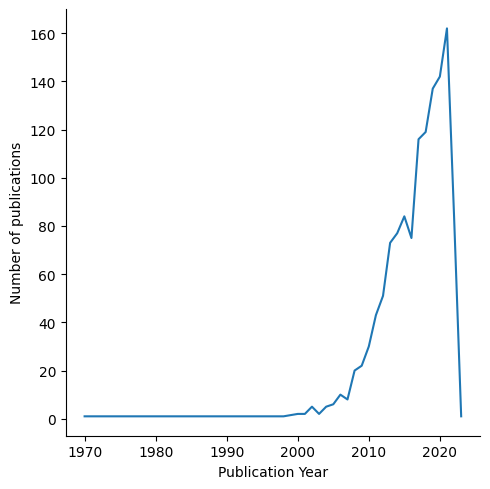

In [5]:

df = pd.read_csv("data/hertie_papers.csv")
yps = (df
        .groupby(["publication_year"])["id"]
        .count()
        .to_frame("n_pubs")
        .reset_index()
      )
ax = sns.relplot(
  data=yps, kind="line", 
  x="publication_year", y="n_pubs"
)
ax.set(xlabel="Publication Year", ylabel="Number of publications")

Text(0.5, 1.0, 'Publications by someone with a Hertie affiliation')

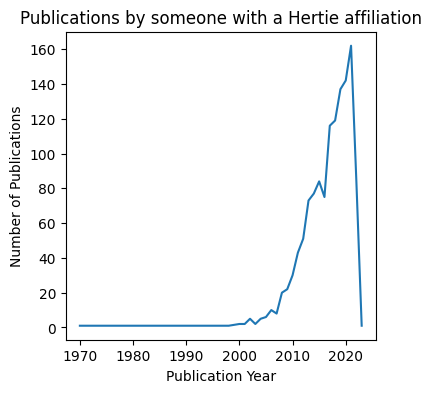

In [6]:
fig, ax = plt.subplots(figsize=(4,4))
df.groupby(["publication_year"])["id"].count().plot(ax=ax)
ax.set_xlabel("Publication Year")
ax.set_ylabel("Number of Publications")
ax.set_title("Publications by someone with a Hertie affiliation")

[Text(0.5, 0, 'Publication Year'), Text(0, 0.5, 'Number of publications')]

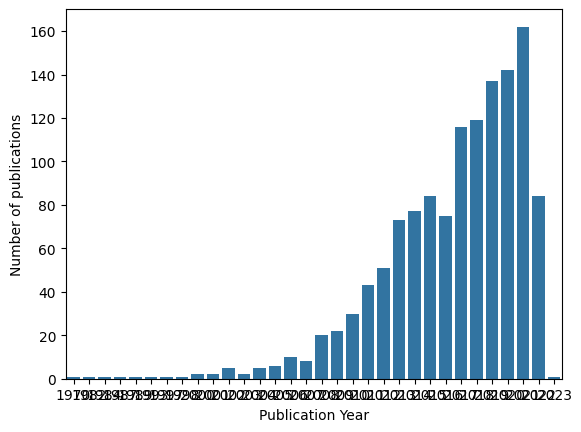

In [7]:
df = pd.read_csv("data/hertie_papers.csv")
yps = (df
        .groupby(["publication_year"])["id"]
        .count()
        .to_frame("n_pubs")
        .reset_index()
      )
ax = sns.barplot(data=yps, x="publication_year", y="n_pubs")
ax.set(xlabel="Publication Year", ylabel="Number of publications")

Text(0.5, 1.0, 'Publications by someone with a Hertie affiliation')

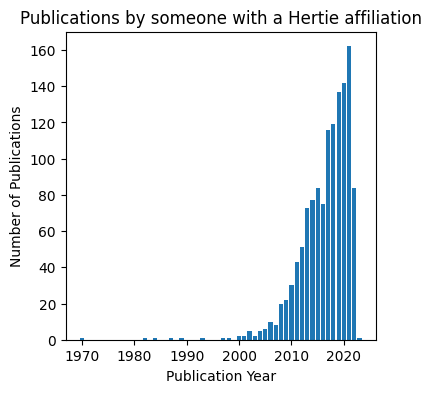

In [8]:
yps = (df
        .groupby(["publication_year"])["id"]
        .count()
        .to_frame("n_pubs")
        .reset_index()
      )
fig, ax = plt.subplots(figsize=(4,4))
ax.bar(yps["publication_year"], yps["n_pubs"])
ax.set_xlabel("Publication Year")
ax.set_ylabel("Number of Publications")
ax.set_title("Publications by someone with a Hertie affiliation")

In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sw
sw_set = set(sw)
sw_set.add("abstract")
vectorizer = CountVectorizer(stop_words=list(sw_set))
df = df[pd.notna(df["abstract"])].reset_index(drop=True)
dfm = vectorizer.fit_transform(df["abstract"])

<Axes: xlabel='count', ylabel='feature'>

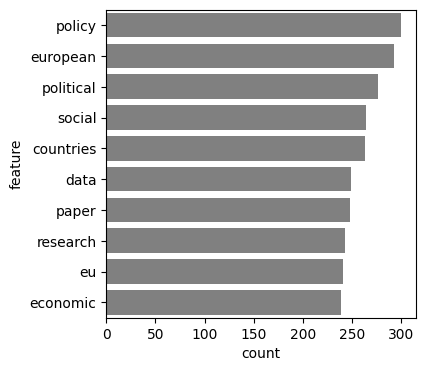

In [10]:
counts = dfm.sum(axis=0).A1
tidy_dfm = pd.DataFrame({
    "count": counts, 
    "feature": vectorizer.get_feature_names_out()
}).sort_values("count",ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(
  data=tidy_dfm.head(10), 
  x="count", y="feature", color="grey"
)

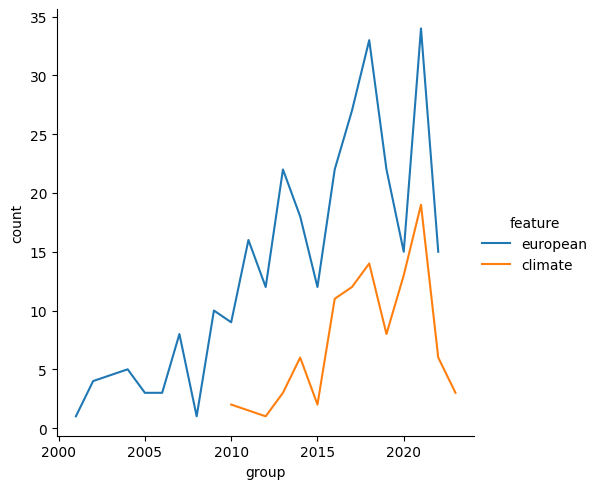

In [11]:
tidy_dfm = pd.DataFrame()
features = vectorizer.get_feature_names_out()
for name, group in df.groupby("publication_year"):
    counts = dfm[group.index,:].sum(axis=0).A1
    group_df = pd.DataFrame({
        "count": counts,
        "feature": features,
        "group": name
    })
    tidy_dfm = pd.concat([
      tidy_dfm, 
      group_df[group_df["count"]!=0]
    ]).reset_index(drop=True)

interesting_features = tidy_dfm[
  tidy_dfm["feature"].isin(["climate","european"])
]
sns.relplot(
  data=interesting_features, x="group", y="count", 
  hue="feature", kind="line"
)

8

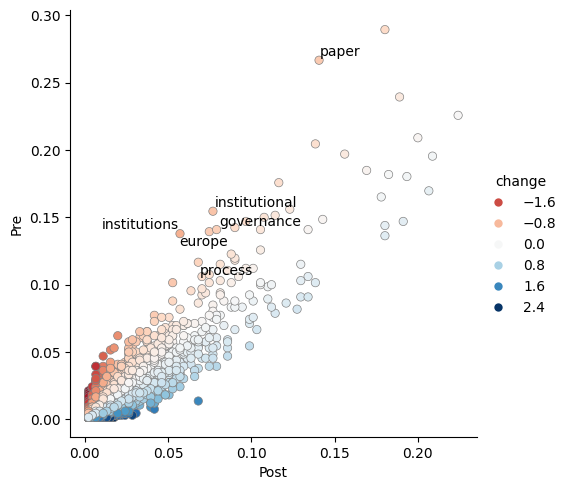

In [12]:
tidy_dfm = pd.DataFrame()
df["era"] = np.where(df["publication_year"]<2019, "Pre", "Post")
for name, group in df.groupby("era"):
    counts = np.count_nonzero(
      dfm[group.index,].A, axis=0
    ) / group.shape[0]
    group_df = pd.DataFrame({
        "count": counts,
        "feature": features,
        "group": name
    })
    tidy_dfm = pd.concat([
      tidy_dfm, group_df[group_df["count"]!=0]
    ]).reset_index(drop=True)
wide_dfm = tidy_dfm.pivot_table(
  index="feature", columns="group", values="count"
).reset_index().reset_index(drop=True)


colormap = cm.RdBu
#norm = CenteredNorm(0)
wide_dfm["change"] = np.log(wide_dfm["Post"] / wide_dfm["Pre"])
norm = CenteredNorm()

labels = wide_dfm[
    (abs(wide_dfm["change"])>0.5) &
    (wide_dfm["Post"]+wide_dfm["Pre"]>.18)
]
scatter = sns.relplot(
    data=wide_dfm, x="Post", y="Pre", hue="change", 
    palette=colormap, 
    hue_norm=norm, 
    edgecolor="grey"
)
ax = scatter.ax
texts = []
for i, row in labels.iterrows():
    texts.append(ax.text(row["Post"], row["Pre"], row["feature"]))

adjust_text(texts)

In [15]:
#Excercise 1: Load the authorship data in data/author_df.csv and make a horizontal bar plot showing the 
# 10 authors who have published the most papers with Hertie affiliations. In python you will need to
# filter data df[df["x"]=="y"], and to use the sort_values() as well as head()/tail()

csv_path = os.path.join(cwd, "data", "hertie_authors.csv")
print(csv_path)
df = pd.read_csv(csv_path)
df.head(3)

c:\Users\kaius\OneDrive - Hertie School\MSc Data Science for Public Policy\Semester_3\Text as Data\text-as-data\Session-5-Visualising\data\hertie_authors.csv


,institution_id,institution_display_name,institution_ror,institution_country_code,institution_type,author_id,author_display_name,author_orcid,id
0,https://openalex.org/I195460627,University of Aberdeen,https://ror.org/016476m91,GB,education,https://openalex.org/A2144380480,Pete Smith,https://orcid.org/0000-0001-6007-2231,https://openalex.org/W2195453830
1,https://openalex.org/I204250578,"University of California, Irvine",https://ror.org/04gyf1771,US,education,https://openalex.org/A2131043496,Steven J. Davis,https://orcid.org/0000-0002-9338-0844,https://openalex.org/W2195453830
2,https://openalex.org/I4577782,Technical University of Berlin,https://ror.org/03v4gjf40,DE,education,https://openalex.org/A2622149569,Felix Creutzig,https://orcid.org/0000-0002-5710-3348,https://openalex.org/W2195453830


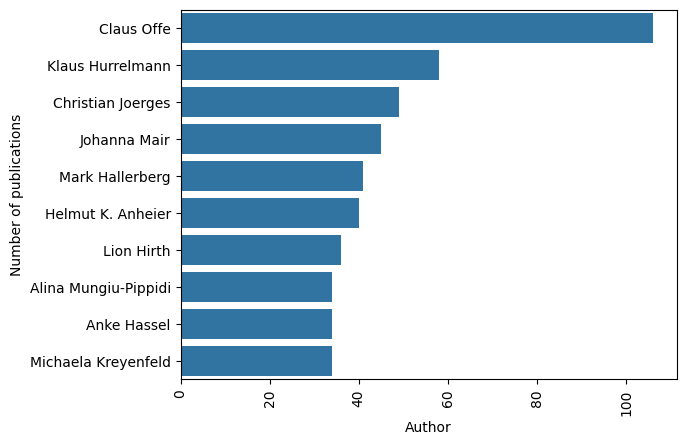

In [24]:
yps = (df[df["institution_display_name"].str.contains("Hertie")]
.groupby(["author_display_name"])["id"]
.count()
.sort_values(ascending=False)
.head(10)
.to_frame("n_pubs")
.reset_index()
)
ax = sns.barplot(data=yps, x="n_pubs", y="author_display_name",)
ax.set(xlabel="Author", ylabel="Number of publications")
plt.xticks(rotation=90)
plt.savefig("plots/pubs_Hertie_bar_sns.png")